In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
from numpy import genfromtxt
dat = genfromtxt('../data/data.csv', delimiter=',')

tobs = dat[:,0]
obs  = dat[:,[1,2,3]]

In [14]:
stan_code = '''
functions {
   real[] npz(real t,       // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // fixed real data (empty)
              int[] x_i) {  // fixed integer data (empty)
   
    /*
    guide to theta:
    theta[1]:  vmax         maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat   nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz         zooplankton grazing rate
    theta[4]:  mort_p       phytoplankton mortality rate
    theta[5]:  mort_z       zooplankton mortality rate
    theta[6]:  irr          light amplitude
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real light = 1.0 + 0.5*(theta[6]*sin(pi()*((t-81.25)/182.5))-theta[6]); 
    real growth = theta[1]*n/(theta[2]+n) * light * p;
    real grazing = theta[3]*p*z;
    real ploss = theta[4]*p;
    real zloss = theta[5]*z*z;
    
    return {-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss};
  }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real tobs[nobs];                 // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
}
parameters {
    real<lower=0> vmax;
    real<lower=0> nuthalfsat;
    real<lower=0> graz;
    real<lower=0> mort_p;
    real<lower=0> mort_z;
    real<lower=0,upper=1> irr;
    real<lower=0> x0[3];            // initial conditions
    real<lower=0> sigma[nobsvar];   // obs error
}
transformed parameters {
    real theta[6] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr};
    real x[nobs, 3] = integrate_ode_rk45(npz, x0, 0, tobs, theta,
                                         rep_array(0.0, 0), rep_array(0, 0),
                                         1e-5, 1e-4, 1e4);
}
model {
    vmax       ~ normal(0.1, 0.1);
    nuthalfsat ~ uniform(0.0, 1.0);
    graz       ~ normal(0.01, 0.01);
    mort_p     ~ normal(0.01, 0.01);
    mort_z     ~ normal(0.01, 0.01);
    irr        ~ uniform(0.0, 1.0);
    x0[1:3]    ~ normal(0.1, 0.1);
    for (iobs in 1:nobs){
        obs[iobs,] ~ normal(x[iobs,iobsvar], sigma);
    }
}
'''

In [15]:
import pystan

In [16]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00918706f3db6263d5fd0d4e61a1c110 NOW.


In [20]:
iobsvar = np.array([0,1,2])

In [31]:
# convert from Python's 0-based indexing to Stan's 1-based
data = {'nobs':len(tobs), 'tobs':tobs, 'nobsvar':len(iobsvar), 'iobsvar':iobsvar+1, 'obs':obs}

In [23]:
mcmc = model.sampling(data=data, iter=2000, chains=4)
print(mcmc)

Inference for Stan model: anon_model_00918706f3db6263d5fd0d4e61a1c110.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vmax         0.08  8.3e-4   0.01   0.06   0.07   0.07   0.09   0.11    246   1.01
nuthalfsat   0.54    0.02   0.24   0.17   0.33   0.51   0.74   0.98    238   1.01
graz         0.02  1.1e-4 3.0e-3   0.01   0.02   0.02   0.02   0.03    729    1.0
mort_p       0.01  2.4e-4 4.8e-3 8.2e-3   0.01   0.01   0.02   0.03    411   1.01
mort_z       0.03  1.9e-4 5.2e-3   0.02   0.03   0.03   0.04   0.04    746    1.0
irr          0.84  6.0e-3    0.1   0.61   0.78   0.86   0.92   0.99    288   1.01
x0[1]        0.44  2.5e-3   0.08   0.28   0.39   0.44    0.5   0.58   1000    1.0
x0[2]        0.26  1.7e-3   0.05   0.18   0.23   0.26   0.29   0.38    848    1.0
x0[3]        0.28  1.7e-3   0.06   0.18   0.24   0.28   0.32   0.39   105

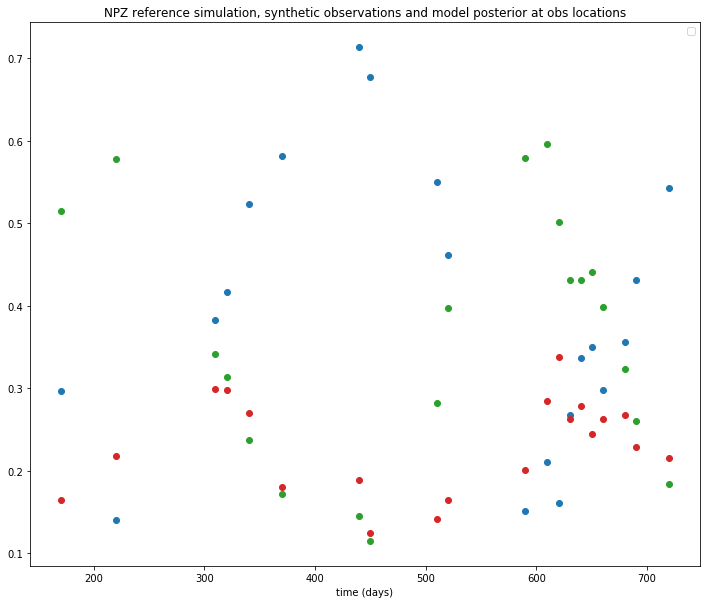

In [33]:
# plot results

colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

x_quant = np.percentile(mcmc['x'], (25,50,75), axis=0)

fig,ax = plt.subplots(figsize=(12,10))

#for i,name in enumerate(('N','P','Z')):
#    ax.plot(t,x[:,i], color=colors[i], label=name)
#    ax.errorbar(x=tobs, y=x_quant[1,:,i], yerr=np.array((x_quant[1,:,i]-x_quant[0,:,i],x_quant[2,:,i]-x_quant[1,:,i])), ls=':', color=colors[i], marker='+', capsize=1.0)
for i, ivar in enumerate(iobsvar):
    ax.plot(tobs, obs[:,i], color=colors[ivar], marker='o', ls='none')
ax.set(title='NPZ reference simulation, synthetic observations and model posterior at obs locations', xlabel='time (days)')
ax.legend()
None

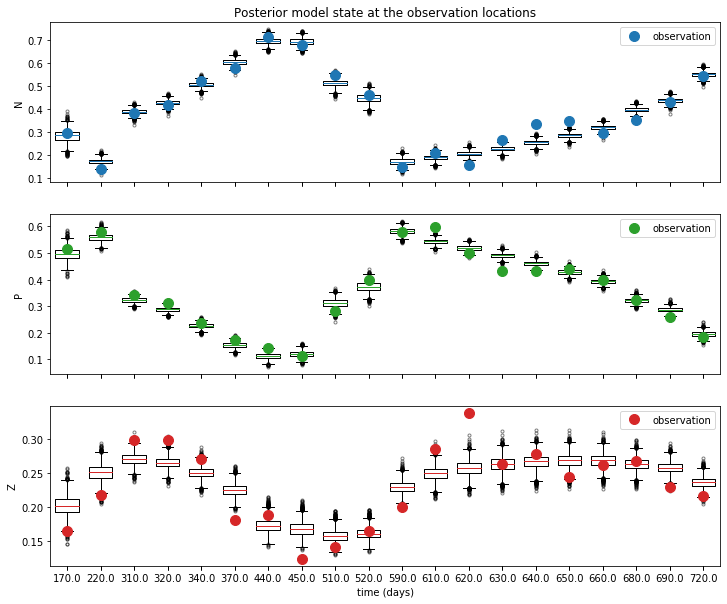

In [35]:
positions = range(len(tobs))

fig,axs = plt.subplots(nrows=3, sharex=True, figsize=(12,10))
for ivar,ax in enumerate(axs.flat):
    ax.boxplot(mcmc['x'][:,:,ivar], positions=positions, medianprops={'color':colors[ivar]}, flierprops={'marker':'.', 'alpha':0.5}, widths=0.7)
    #ax.plot(positions, x[iobs,ivar], marker='x', markeredgewidth=3, markersize=10, ls='none', label='true state', color=colors[ivar])
    ax.set(ylabel='NPZ'[ivar])
for i,ivar in enumerate(iobsvar):
    axs[ivar].plot(positions, obs[:,i], marker='o', markersize=10, ls='none', label='observation', color=colors[ivar])
for ax in axs.flat:
    ax.legend()
axs[0].set(title='Posterior model state at the observation locations')
axs[-1].set(xticklabels=tobs, xlabel='time (days)')
None

In [ ]:
parameter_names = [k for k in theta.keys()]
nparam = len(parameter_names)
cmap = plt.get_cmap('gray_r')

fig,axs = plt.subplots(nrows=nparam-1, ncols=nparam-1, sharex='col', sharey='row', figsize=(12,12))
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,nparam):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = parameter_names[icol]
        yname = parameter_names[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=cmap)
        ax.axvline(theta[xname], color='darkred', alpha=0.3)
        ax.axhline(theta[yname], color='darkred', alpha=0.3)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == nparam-1:
            ax.set_xlabel(xname)